#한국 기사 댓글들을 워드 임베딩하여 연관된 단어 찾아내기

In [1]:
pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 15.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request  #url을 읽는 모듈
from gensim.models.word2vec import Word2Vec , KeyedVectors#word2vec설치
from konlpy.tag import Okt #한글 형태소 분석
from tqdm import tqdm

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/kocohub/korean-hate-speech/master/unlabeled/unlabeled_comments_1.txt", filename="comments1.txt")

('comments1.txt', <http.client.HTTPMessage at 0x79f85253d180>)

In [4]:
train_data = pd.read_table('comments1.txt', error_bad_lines=False, names=["comments"]) #컬럼명을 comments로

<ipython-input-4-d6ae96c7d2b6>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  train_data = pd.read_table('comments1.txt', error_bad_lines=False, names=["comments"]) #컬럼명을 comments로
Skipping line 111106: expected 1 fields, saw 416
Skipping line 118694: expected 1 fields, saw 1036
Skipping line 239060: expected 1 fields, saw 1041
Skipping line 373827: expected 1 fields, saw 131
Skipping line 440940: expected 1 fields, saw 111



In [5]:
train_data[:10] # 상위 5개 출력

,comments
0,지드래곤은 난봉꾼이란...댓글도 달렸네 ㅋㅋ 이주연 학창시절 사진 보고 와라. 요즘...
1,이주연은 알겠는데 지디는 뭐하는 듣보잡여
2,부럽네요. 나도 불과 한달전까진 허니문베이비를 꿈꿨는데 이제 다 부질없네요. 당연히...
3,이주연을 모르는 애들이 많네. 해체된 애프터스쿨 멤버로 당시는 주연이 예명. 인기나...
4,겨론했으면
5,이주연이 아깝다 진심
6,방탄은 건드리지말자 인간적으로.. 해외활동 지금주터 시작인데 터지면 진짜 전 세계적...
7,선남선녀의 만남이네요^^
8,문재앙 또뭘덥고 싶어서 ㄷㄷㄷ
9,주연이 아깝긴해요


In [6]:
print(len(train_data)) # 댓글 개수 출력

499995


#전처리 시작
### 1.결측값 삭제
### 2.한국어 이외 제거하는 전처리
### 3 불용어 제거

In [7]:
# NULL 값 존재 유무 (있음)
print(train_data.isnull().values.any())

True


In [8]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [9]:
print(len(train_data)) # null값 지운 댓글갯수

499915


In [10]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['comments'] = train_data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

<ipython-input-10-67b027982a8d>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['comments'] = train_data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [11]:
train_data[:10] # 상위 5개 출력

,comments
0,지드래곤은 난봉꾼이란댓글도 달렸네 ㅋㅋ 이주연 학창시절 사진 보고 와라 요즘 웬만한...
1,이주연은 알겠는데 지디는 뭐하는 듣보잡여
2,부럽네요 나도 불과 한달전까진 허니문베이비를 꿈꿨는데 이제 다 부질없네요 당연히 순...
3,이주연을 모르는 애들이 많네 해체된 애프터스쿨 멤버로 당시는 주연이 예명 인기나 포...
4,겨론했으면
5,이주연이 아깝다 진심
6,방탄은 건드리지말자 인간적으로 해외활동 지금주터 시작인데 터지면 진짜 전 세계적으로...
7,선남선녀의 만남이네요
8,문재앙 또뭘덥고 싶어서 ㄷㄷㄷ
9,주연이 아깝긴해요


In [12]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# Okt (Open Korean Text): 한글 형태소 분석 등을 위해 필요
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['comments']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)



100%|██████████| 499915/499915 [45:25<00:00, 183.43it/s]


리뷰의 최대 길이 : 200
리뷰의 평균 길이 : 14.059322084754408


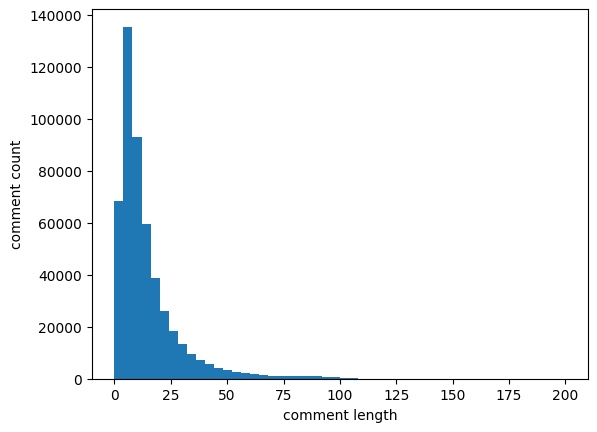

In [13]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('comment length')
plt.ylabel('comment count')
plt.show()

In [14]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data,
                 vector_size = 300, #벡터 차원
                 window = 15,  # 윈도우 크기
                 min_count = 5,  #최소 단어 수
                 workers = 4,  #병렬로 처리하는 데 사용되는 작업자 수
                 sg = 0)

In [15]:
model.wv.vectors.shape


(29379, 300)

In [16]:
print(model.wv.most_similar("지드래곤"))

[('대마초', 0.6531737446784973), ('선양', 0.6443856954574585), ('대마', 0.6409093737602234), ('권지용', 0.6392685770988464), ('국위', 0.5985285639762878), ('빅뱅', 0.597901463508606), ('유승준', 0.5880511999130249), ('미필', 0.5872591137886047), ('정용화', 0.5824089646339417), ('병역', 0.5785806775093079)]


In [17]:
print(model.wv.most_similar("예능"))

[('예능인', 0.6396871209144592), ('다큐', 0.6338025331497192), ('포맷', 0.6322923302650452), ('프로그램', 0.6156779527664185), ('프로', 0.6027464270591736), ('리얼리티', 0.5885072946548462), ('게스트', 0.5773921012878418), ('개그', 0.5764940977096558), ('무한도전', 0.5763490200042725), ('공중파', 0.5693693161010742)]


In [ ]:
print(model.wv.most_similar("대마초"))

[('대마', 0.8689255714416504), ('마약', 0.7537370324134827), ('코카인', 0.7046219110488892), ('엑스터시', 0.6873170733451843), ('씨잼', 0.6646226048469543), ('합법', 0.6633061170578003), ('흡연', 0.6500153541564941), ('지드래곤', 0.6364442110061646), ('불법', 0.6267058849334717), ('반입', 0.6149749159812927)]


In [ ]:
print(model.wv.most_similar("북한"))

[('김정은', 0.8394749760627747), ('북', 0.7675672173500061), ('남한', 0.7517381310462952), ('김일성', 0.7495707273483276), ('남북', 0.747141420841217), ('평화', 0.7457470297813416), ('회담', 0.7382364273071289), ('트럼프', 0.7274119853973389), ('평양', 0.7237446308135986), ('빨갱이', 0.7223802208900452)]


In [ ]:
print(model.wv.most_similar("구글"))

[('최단', 0.5759780406951904), ('유튜브', 0.5697177648544312), ('홈페이지', 0.559505820274353), ('실시간', 0.5588559508323669), ('유료', 0.5583877563476562), ('포털', 0.558098554611206), ('꼴등', 0.5565248131752014), ('파이브', 0.5535078048706055), ('아메리카', 0.5512233972549438), ('포털사이트', 0.5510962605476379)]


In [ ]:
print(model.wv.most_similar("월드컵"))

[('경기', 0.6996333599090576), ('야구', 0.6794438362121582), ('올림픽', 0.6663774847984314), ('독일', 0.6525552868843079), ('축구', 0.646243691444397), ('스웨덴', 0.6347187161445618), ('북미', 0.6157695055007935), ('컬링', 0.6052615642547607), ('공연', 0.5942294597625732), ('멕시코', 0.5892632603645325)]


In [ ]:
print(model.wv.most_similar("유재석"))

[('박명수', 0.7475533485412598), ('정준하', 0.7293365597724915), ('유느님', 0.6958364248275757), ('정형돈', 0.6934395432472229), ('강호동', 0.6901072859764099), ('조세호', 0.6858330368995667), ('무한도전', 0.6841861009597778), ('신동엽', 0.6669977903366089), ('김태호', 0.6618503332138062), ('노홍철', 0.6528859734535217)]


In [18]:
print(model.wv.most_similar("무한도전"))

[('무도', 0.8172489404678345), ('김태호', 0.7615554332733154), ('노홍철', 0.7488672137260437), ('정형돈', 0.7466946244239807), ('유재석', 0.6925585865974426), ('나영석', 0.6840500831604004), ('폐지', 0.6834907531738281), ('포맷', 0.6812383532524109), ('정준하', 0.6731865406036377), ('특집', 0.6525757908821106)]


In [19]:
print(model.wv.most_similar("올림픽"))

[('평창', 0.7273550629615784), ('공연', 0.6992472410202026), ('북미', 0.6908532381057739), ('폐막식', 0.6891611218452454), ('평양', 0.6633020043373108), ('월드컵', 0.6602241396903992), ('금메달', 0.6483744978904724), ('경기', 0.6396518349647522), ('중계', 0.6387832164764404), ('평창올림픽', 0.6379588842391968)]


In [20]:
print(model.wv.most_similar("강동원"))

[('원빈', 0.7513214945793152), ('송승헌', 0.7272949814796448), ('조인성', 0.6910160779953003), ('장동건', 0.6771702766418457), ('한효주', 0.6725264191627502), ('정우성', 0.6670779585838318), ('송중기', 0.648743748664856), ('이정재', 0.6361550092697144), ('김수현', 0.631850004196167), ('송혜교', 0.6170444488525391)]


In [30]:

loaded_model

In [23]:
model.wv.save_word2vec_format('./comment_test') #모델저장
loaded_model = KeyedVectors.load_word2vec_format('./comment_test') #모델로드

In [ ]:
from gensim.models import Word2Vec
from gensim.scripts import word2vec2tensor
import os

In [ ]:
with open('/content/word_embeddings.tsv', 'w', encoding='utf-8') as f:
    for word in model.wv.index_to_key:
        vector = '\t'.join(map(str, model.wv[word]))
        f.write(f'{word}\t{vector}\n')

In [ ]:
!python -m gensim.scripts.word2vec2tensor --input comment_test --output comment_test

2023-12-21 19:22:40,917 - word2vec2tensor - INFO - running /usr/local/lib/python3.10/dist-packages/gensim/scripts/word2vec2tensor.py --input comment_test --output comment_test
2023-12-21 19:22:40,918 - keyedvectors - INFO - loading projection weights from comment_test
2023-12-21 19:22:48,367 - utils - INFO - KeyedVectors lifecycle event {'msg': 'loaded (29379, 300) matrix of type float32 from comment_test', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-12-21T19:22:48.366039', 'gensim': '4.3.2', 'python': '3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]', 'platform': 'Linux-6.1.58+-x86_64-with-glibc2.35', 'event': 'load_word2vec_format'}
2023-12-21 19:22:54,446 - word2vec2tensor - INFO - 2D tensor file saved to comment_test_tensor.tsv
2023-12-21 19:22:54,447 - word2vec2tensor - INFO - Tensor metadata file saved to comment_test_metadata.tsv
2023-12-21 19:22:54,450 - word2vec2tensor - INFO - finished running word2vec2tensor.py


In [ ]:
from gensim.models import Word2Vec

model2 = Word2Vec(sentences = tokenized_data,
                 vector_size = 300,
                 window = 20,
                 min_count = 50,
                 workers = 4,
                 sg = 0)

In [ ]:
model2.wv.vectors.shape

(9345, 300)

In [ ]:
model.wv.save_word2vec_format('./comment_test2') #모델저장
loaded_model = KeyedVectors.load_word2vec_format('./comment_test2') #모델로드

In [ ]:
!python -m gensim.scripts.word2vec2tensor --input comment_test2 --output comment_test2

2023-12-21 19:37:49,267 - word2vec2tensor - INFO - running /usr/local/lib/python3.10/dist-packages/gensim/scripts/word2vec2tensor.py --input comment_test2 --output comment_test2
2023-12-21 19:37:49,268 - keyedvectors - INFO - loading projection weights from comment_test2
2023-12-21 19:37:56,773 - utils - INFO - KeyedVectors lifecycle event {'msg': 'loaded (29379, 300) matrix of type float32 from comment_test2', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-12-21T19:37:56.771393', 'gensim': '4.3.2', 'python': '3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]', 'platform': 'Linux-6.1.58+-x86_64-with-glibc2.35', 'event': 'load_word2vec_format'}
2023-12-21 19:38:03,227 - word2vec2tensor - INFO - 2D tensor file saved to comment_test2_tensor.tsv
2023-12-21 19:38:03,227 - word2vec2tensor - INFO - Tensor metadata file saved to comment_test2_metadata.tsv
2023-12-21 19:38:03,238 - word2vec2tensor - INFO - finished running word2vec2tensor.py


In [ ]:
from google.colab import files

# 파일 다운로드
files.download('/content/comment_test')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# 파일 다운로드
files.download('/content/comment_test2_metadata.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# 파일 다운로드
files.download('/content/comment_test2_tensor.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>